# **<center>Dental Cavity Detection</center>**

- **Step 1: Perform the Data Augmentation**
- **Step 2: Preprocess the Dataset**
- **Step 3: Visualize the Data with its Annotations**
- **Step 4: Split the Data into Train and Validation Set**
- **Step 5: Construct the Multi Output Model**
- **Step 6: Compile & Train the Model**
- **Step 7: Plot Model’s Loss & Accuracy Curves**
- **Step 8: Test your model on New Images**



Make sure you have imgaug library installed.

In [1]:
!pip install imgaug

In [2]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(100)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD #Stochatic Gradient Descent
#from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from keras import backend as K 
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os
import glob

import imgaug as ia
ia.seed(1)

%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 


import imageio
import pandas as pd
import numpy as np
import re #Regular Expression

import shutil

In [3]:
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
classes_list = sorted(['cavity',  'filling', 'implant'])

import pandas as pd
labels_df = pd.read_csv("/content/drive/My Drive/new_labels.csv")
labels_df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cavity/1.jpg,275,183,cavity,78,6,128,61
1,cavity/10.jpg,450,337,cavity,79,13,141,56
2,filling/100.jpg,300,200,filling,45,55,165,153
3,filling/101.jpg,1024,729,filling,257,243,489,390
4,filling/102.jpg,620,438,filling,364,65,553,190
5,implant/104.jpg,255,198,implant,121,91,158,180
6,implant/105.jpg,254,199,implant,90,87,138,183
7,implant/106.jpg,251,201,implant,110,15,154,138
8,implant/107.jpg,198,254,implant,69,23,112,132
9,implant/108.jpg,198,254,implant,84,5,137,101


In [ ]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):

    # Converting the Bounding Box Objects to Array
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
    
    # Converting the array into DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array, 
                                     columns=['xmin', 'ymin', 'xmax', 'ymax'])
    
    # Return the DataFrame
    return df_bounding_boxes

### **Initialize the Augmentations**

In [ ]:
# Define all the Augmentations you want to apply to your dataset
# We're setting random `n` agumentations to 2. 
image_augmentations = iaa.SomeOf( 2,
    [                                 
    # Scale the Images, Increasing or decreasing the size of the image
    iaa.Affine(scale=(0.5, 1.5)),

    # Rotate the Images to -60 and 60 degrees
    iaa.Affine(rotate=(-60, 60)),

    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),

    # Fliping the image horizontally
    iaa.Fliplr(1),

    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),

    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))

])

In [ ]:
image_directory = '/content/drive/My Drive/dataset'

### **Create a Function to Apply Augmentations**

In [ ]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 3):
    
    # Fill this DataFrame with image attributes
    augmentations_df = pd.DataFrame(
        columns=['filename','width','height','class', 'xmin', 'ymin', 'xmax',
                 'ymax'])
    
    # Group the data by filenames
    grouped_df = df.groupby('filename')

    # Create the directory for all augmentated images
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)

    # Create directories for each class of augmentated images
    for folder in df['class'].unique():
      if not os.path.exists(os.path.join(aug_images_path, folder)):
        os.mkdir(os.path.join(aug_images_path, folder))

    for i in range(multiple):
      
      # Post Fix we add to the each different augmentation of one image
      image_postfix = str(i)

      # Loop to perform the augmentations
      for filename in df['filename'].unique():

        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'

        # Take one image at a time with its information
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
        
        # Read the image
        image = imageio.imread(os.path.join(images_path, filename))

        # Get bounding box
        bounding_box_array = single_image.drop(['filename', 'width', 'height',
                                                'class'], axis=1).values

        # Give the bounding box to imgaug library
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, 
                                                            shape=image.shape)

        # Perform random 2 Augmentations
        image_aug, bounding_box_aug = augmentor(image=image, 
                                                bounding_boxes=bounding_box)
        
        # Discard the the bounding box going out the image completely   
        bounding_box_aug = bounding_box_aug.remove_out_of_image()

        # Clip the bounding box that are only partially out of th image
        bounding_box_aug = bounding_box_aug.clip_out_of_image()

        # Get rid of the the image if bounding box was discarded  
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
        
        else:
        
          # Create the augmented image file
          imageio.imwrite(augmented_path, image_aug) 

          # Update the image width and height after augmentation
          info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'width'] = image_aug.shape[1]
              info_df.at[index, 'height'] = image_aug.shape[0]

          # Add the prefix to each image to differentiate if required
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')

          # Create the augmented bounding boxes dataframe 
          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)

          # Concatenate the filenames, height, width and bounding boxes 
          aug_df = pd.concat([info_df, bounding_box_df], axis=1)

          # Add all the information to augmentations_df we initialized above
          augmentations_df = pd.concat([augmentations_df, aug_df])            
      
    # Remove index
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)

    # Return the Dataframe
    return augmentations_df


augmented_images_df = image_aug(labels_df, image_directory, 'aug_images', 
                                image_augmentations)

Apply the function above to do augmentation

In [ ]:
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('aug.csv')

# Check Dataset Size
print('Our total dataset Size before the augmentations was: ', len(labels_df))
print('Our total dataset Size after the augmentations is: ', len(augmented_images_df))

Our total dataset Size before the augmentations was:  83
Our total dataset Size after the augmentations is:  245


## **Preprocess the Dataset**
Scaling the bouding boxes in the range of 0-1 because it is easy for a model to understand.
Other functions like resizing is also performed.

In [ ]:
def preprocess_dataset(image_folder, classes_list, df, image_size = 300,):


  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  # Get height and width of each image in the datafame
  h = df['height']
  w = df['width']

  # Create a copy of the labels in the dataframe
  labels = list(df['class'])

  # Create a copy of the bounding box values and also normalize them 
  for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h), 
                            list(df['xmax']/w), list(df['ymax']/h)):
    
    arr = [x1, y1, x2, y2]
    boxes.append(arr)

  # We loop over each class and its labels 
  for class_folder in classes_list:  

    # Set our images directory
    image_dir = os.path.join(image_folder, class_folder)

    # Annotation and Image files
    img_files = sorted(os.listdir(image_dir))

    # Loop over each of the image and its label
    for image_file in img_files:

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Read the image
      img  = cv2.imread(img_path)

      # Resize all images to a fix size
      image = cv2.resize(img, (image_size, image_size))

      # Convert the image from BGR to RGB
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Normalize the image by dividing it by 255.0 
      image = image.astype("float") / 255.0

      # Append it to the list of images
      img_list.append(image)

  return labels, boxes, img_list

Now call the preprocessing function

In [ ]:
# All images will resized to 300, 300 
image_size = 300

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset('aug_images', classes_list,
                                             augmented_images_df)

In [ ]:
# Convert labels to integers, then one hot encode them
label_encoder = LabelEncoder() #To convert text into numerical data for model's better understanding
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels) #Converting categorical data in the form of numbers for model's better understanding

## **Visualize the Data with its Annotations**
Verify if the augmentations are done correctly.

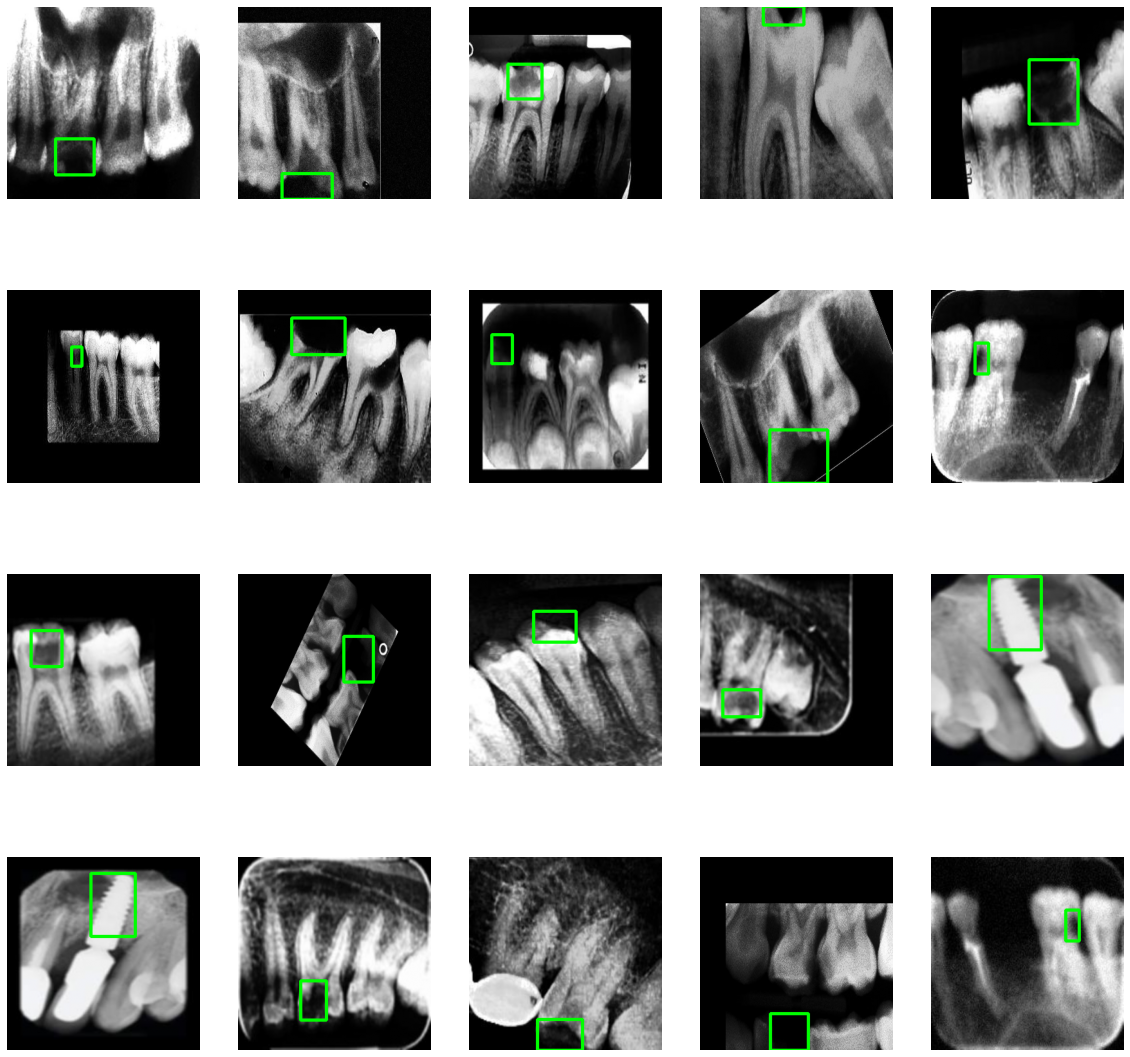

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for iteration, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];

    # Rescaling the boundig box values to match the image size
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(image);
    plt.axis('off');

## **Split the Data into Train and Validation Set**



In [ ]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size = 0.1, 
                random_state = 43)

print('Total Training Images: {}, Total Validation Images: {}'.format(
    len(train_images), len(val_images) ))

Total Training Images: 220, Total Validation Images: 25


## **Constructing a Multi Output Model**
Transfer learning is used to save the model to start the training from scratch. The model we’ll use for transfer learning is NasnetMobile. This is a really efficient model with a good balance of speed and accuracy


In [ ]:
# Load the NasNetMobile Model, make sure to exclude the top for transfer learning
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet')

In [ ]:
# Let's create a function that will construct our model
def create_model(no_of_classes):

    # Freeze the whole model
    N_mobile.trainable = False
    
    # Start by taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output
    
    # Convert to a single-dimensional vector by Global Average Pooling.

    # We could also use Flatten()(x) but GAP is more effective, it reduces 
    # Parameters and controls overfitting.
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Create our Classification Head, final layer contains 
    # Ouput units = no. classes
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',
                             name="class_output")(class_prediction)

    # Create Our Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    # Respectively.
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )

    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Now combine the two heads
    model = Model(inputs=N_mobile.input, outputs= [box_predictions, 
                                                   class_prediction])

    return model

# Create the model for 3 classes, Elephant, Butterfly, Cougar-Face
model = create_model(3); print("Model Created")

Model Created


# CNN Model For Class Predictions

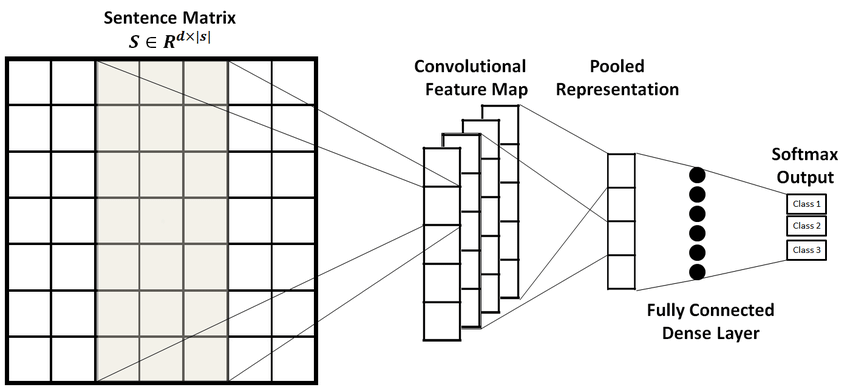

# CNN Model For Box Predictions

# 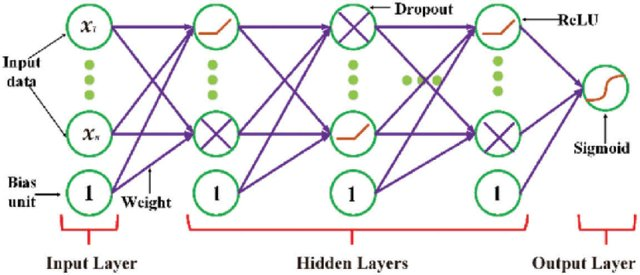

## **Compile & Train the Model**


Since it is a multi output model that outputs two totally different things so we need to use seperate loss and separate metrics for both of these output branches.

In [ ]:
# Here for each head we will define a different loss, we will define it 
# Like a dictionary.

# For classification we will have cateogirical crossentropy
# For the bouding boxes we will have mean squared error
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }

# Here you can give more or less weightage to each loss. 

# If you think that detection is harder then the classification then you can 
# Try assinging it more weight
loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

# Set the Metrics
# For the class labels we want to know the Accuracy
# And for the bounding boxes we need to know the Mean squared error
metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

# # We will be using early stopping to stop the model if total val loss does not
# # Decrease by 0.001 in 40 epochs
# stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
#                     restore_best_weights = True
#                      )

# # Change the learning rate according to number of epochs to boost learning
# reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
#                               patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = SGD(lr = 1e-3, momentum = 0.9)

# Compile the model with Adam optimizer
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)

### **Start Training:**
When you're dealing with a multi output model then you need to assingn individual branches labels seperately like a dictionary. 

In [ ]:
# Train the Model
history = model.fit(x = train_images, 
                    y= {
                        "box_output": train_boxes, 
                        "class_output": train_labels
                        }, 
                    validation_data=(
                        val_images, 
                        {
                          "box_output": val_boxes, 
                          "class_output": val_labels
                          }), batch_size = 32, epochs = 10000)

Streaming output truncated to the last 5000 lines.
Epoch 7501/10000
7/7 [==============================] - 1s 152ms/step - loss: 0.0043 - box_output_loss: 0.0043 - class_output_loss: 4.8551e-06 - box_output_mse: 0.0043 - class_output_accuracy: 1.0000 - val_loss: 0.8071 - val_box_output_loss: 0.0412 - val_class_output_loss: 0.7659 - val_box_output_mse: 0.0412 - val_class_output_accuracy: 0.9200
Epoch 7502/10000
7/7 [==============================] - 1s 154ms/step - loss: 0.0039 - box_output_loss: 0.0038 - class_output_loss: 3.3294e-05 - box_output_mse: 0.0038 - class_output_accuracy: 1.0000 - val_loss: 0.8070 - val_box_output_loss: 0.0412 - val_class_output_loss: 0.7659 - val_box_output_mse: 0.0412 - val_class_output_accuracy: 0.9200
Epoch 7503/10000
7/7 [==============================] - 1s 151ms/step - loss: 0.0041 - box_output_loss: 0.0040 - class_output_loss: 3.8948e-05 - box_output_mse: 0.0040 - class_output_accuracy: 1.0000 - val_loss: 0.8070 - val_box_output_loss: 0.0412 - val_cl

## **Plot Model’s Loss & Accuracy Curves**


In [ ]:
def plot(var1, var2, plot_name):
  # Get the loss metrics from the trained model
  c1 = history.history[var1]
  c2 = history.history[var2]

  epochs = range(len(c1))
  
  # Plot the metrics
  plt.plot(epochs, c1, 'b', label=var1)
  plt.plot(epochs, c2, 'r', label=var2)
  plt.title(str(plot_name))
  plt.legend()

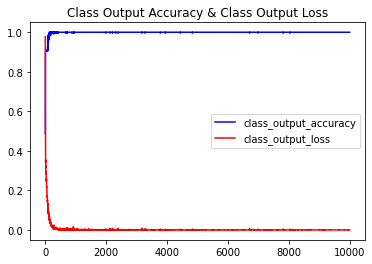

In [ ]:
plot('class_output_accuracy','class_output_loss','Class Output Accuracy & Class Output Loss')

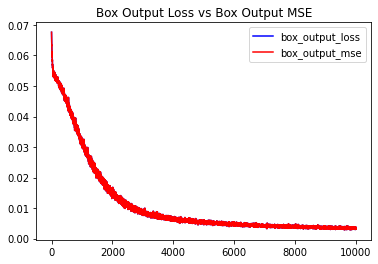

In [ ]:
plot('box_output_loss','box_output_mse','Box Output Loss vs Box Output MSE')

In [ ]:
# These are the most important metrics in telling us how our model is doing
# plot('Total loss','val_loss',' Total Loss vs Total Validation Loss')

### **Save Your Model**


In [6]:
# Save your model here in .h5 format.
#model.save('/content/drive/My Drive/train_10000.h5')

# Load the saved model
model = load_model('/content/drive/My Drive/train_10000.h5')

## **Test your model on New Images**

In [7]:
# Enter your class names in this list
global label_names

# Must be same as Annotations list we used to choose the data
label_names = sorted(classes_list)

### **Predict Function**
Here we will create a function that that will use the model to predict on new images.


In [8]:
# We will use this function to make prediction on images.
def predict(image, returnimage = False,  scale = 0.9):
  
  # Before we can make a prediction we need to preprocess the image.
  processed_image = preprocess(image)

  # Now we can use our model for prediction
  results = model.predict(processed_image)

  # Now we need to postprocess these results.
  # After postprocessing, we can easily use our results
  label, (x1, y1, x2, y2), confidence = postprocess(image, results)

  # Now annotate the image
  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      image, 
      '{}'.format(label, confidence), 
      (x1, y2 + int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (0, 0, 255),
      2
      )

  # Show the Image with matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(image[:,:,::-1])

### **Preprocessing Funciton**
This function will preprocess new images in the same way we did initially before training.

In [9]:
# This function will preprocess images.
def preprocess(img, image_size = 300):
  
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) #Expand dimension of array
    return image

### **Post Processing Function**
After the prediction, you need to do some postprocessing in order to extract the class label and the real boudning box coordinates.

In [10]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    bounding_box, class_probs = results

    # First get the class label

    # The index of class with the highest confidence is our target class
    class_index = np.argmax(class_probs)
  
    # Use this index to get the class name.
    class_label = label_names[class_index]

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = image.shape[:2]

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable and coordinates
    return class_label, (x1,y1,x2,y2),class_probs

Now that we created all the required functions, lets test our model on new images




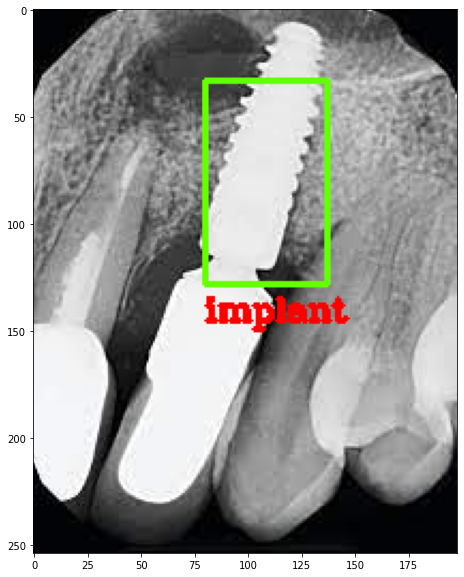

In [11]:
import cv2
#image = cv2.imread('/content/drive/My Drive/decay071.jpg')
image = cv2.imread('/content/drive/My Drive/toothimplant.jpg')
predict(image, scale = 0.5)